In [1]:
import numpy as np 
import pandas as pd
import os
import scipy.stats as ss
import matplotlib.pyplot as plt
import tensorflow as tf
import sklearn
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor,plot_importance
from scipy.stats import f_oneway
from keras.callbacks import EarlyStopping, ModelCheckpoint


In [ ]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # 텐서플로가 첫 번째 GPU에 1GB 메모리만 할당하도록 제한
  try:
    tf.config.experimental.set_virtual_device_configuration(
        gpus[0],
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)])
  except RuntimeError as e:
    # 프로그램 시작시에 가상 장치가 설정되어야만 합니다
    print(e)

In [2]:
sales = pd.read_csv('D:/승찬/수요 예측/rossmann-store-sales/train.csv')
store = pd.read_csv('D:/승찬/수요 예측/rossmann-store-sales/store.csv')
future_sales = pd.read_csv('D:/승찬/수요 예측/rossmann-store-sales/test.csv')
sales['StateHoliday'] = sales['StateHoliday'].replace({0:"0"})
sales['StateHoliday'] = sales['StateHoliday'].replace({'0':'d'})

D:\ANACONDA1\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
def processing_data(sales,store) :
    sales['Date'] = pd.to_datetime(sales['Date'], format="%Y-%m-%d") # 년도, 달, 일 순으로 format
    sales['StateHoliday'] = sales['StateHoliday'].replace({0:"0"})
    sales['StateHoliday'] = sales['StateHoliday'].replace({'0':'d'})
    sales = sales.sort_values('Date')
    
    one_hot = []
    for i in range(0,len(sales)) :
        one_hot.append(0)
        
    name = ['StateHoliday_a','StateHoliday_b','StateHoliday_c','StateHoliday_d']
    values = ['a','b','c','d']
    counts = sales['StateHoliday'].value_counts().sort_index().index

    for i in range(0,len(values)) :
        if values[i] not in counts :
            sales[name[i]] = one_hot        
    sales = pd.get_dummies(data = sales, columns = ['StateHoliday'])
    columns = sales.columns.tolist()
    columns.sort()
    sales = sales[columns]
    
    store = processing_store(store)
    store_copy = store
    store_copy= pd.merge(left=sales,right=store_copy,on='Store')

    store_copy['Year']=pd.DatetimeIndex(store_copy.Date).year
    store_copy['Month']=pd.DatetimeIndex(store_copy.Date).month
    store_copy['Day']=pd.DatetimeIndex(store_copy.Date).day
    if 'Id' in sales :
        store_copy = store_copy.drop(['Date','Store','Id'],axis=1)
    else :
        store_copy = store_copy.drop(['Date','Store','Customers'],axis=1)
        
    target_col = 'Sales'
    input_cols = store_copy.columns.drop(target_col)        
    features = store_copy[input_cols]
    target = store_copy[target_col]
    target = pd.DataFrame(target.values.reshape(-1,1))
        
#     StandardScaler
#     scaler = StandardScaler().fit(store_copy)
#     store_copy = pd.DataFrame(scaler.transform(store_copy),
#                              index = store_copy.index, columns = store_copy.columns)
    
#    MinMaxScaler
#     scaler = MinMaxScaler().fit(store_copy)
#     store_copy = pd.DataFrame(scaler.transform(store_copy),
#                              index = store_copy.index, columns = store_copy.columns)

#     store_copy = feature_engineering_scaling(store_copy)
            
    return make_regression_model_1(features,target)

def processing_store(store) :
    store_copy = store.copy()
    store_copy['CompetitionDistance'] = store_copy['CompetitionDistance'].fillna(
        store_copy['CompetitionDistance'].mean())

    store_copy_cols = ['CompetitionOpenSinceYear','CompetitionOpenSinceMonth',
                    'Promo2SinceWeek','Promo2SinceYear','PromoInterval']
    for i in store_copy_cols :
        store_copy[i].fillna(0,inplace=True)
    store_copy = pd.get_dummies(data=store_copy,columns=['Assortment','PromoInterval','StoreType'])
    return store_copy   

def scaling_data(scaler,features,target) :
    global scaler2
    if scaler == StandardScaler :
        scaler1 = StandardScaler().fit(features)
#         scaler2 = StandardScaler().fit(target)
        features = pd.DataFrame(scaler1.transform(features),
                               index = features.index, columns = features.columns)
#         target = pd.DataFrame(scaler2.transform(target),
#                              index = target.index, columns = target.columns)
        target = np.log1p(target)
    elif scaler == MinMaxScaler : 
        scaler1 = StandardScaler().fit(features)
        scaler2 = MinMaxScaler().fit(target)
        features = pd.DataFrame(scaler1.transform(features),
                               index = features.index,columns = features.columns)
        target = pd.DataFrame(scaler2.transform(target),
                             index = target.index, columns = target.columns)
    elif scaler == normal :
        return features,target
        
    
    return features,target




def inverse_scaling(target) :
    global scaler2
    inverse_scaled_data = scaler2.inverse_transform(target)
    
    return inverse_scaled_data
    
    

def make_regression_model_1(features,target) :
    features, target = scaling_data(StandardScaler,features,target)
    train_x,test_x,train_y,test_y = train_test_split(features,
                                                    target,
                                                    test_size=0.4,random_state=1)
    
    test_x,val_x,test_y,val_y = train_test_split(test_x,
                                                test_y,
                                                test_size=0.5)
       
    return train_x,test_x,val_x,train_y,test_y,val_y

def type_name(feature,target,loss_function) :
    data = [feature+'_'+target+'_'+loss_function+'_param',
            feature+'_'+target+'_'+loss_function+'_predict',
            feature+'_'+target+'_'+loss_function+'_hist']
    return data

# Normalization

In [4]:
def make_resultfile(history,data,pred,actual) :
    filename = data
    
    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'])
    plt.legend(['mean_absolute_error','val_mean_absolute_error'])
    plt.xlabel('epochs')
    plt.ylabel('mean_absolute_error')
    plt.grid()
    plt.savefig(data[0])    
    plt.clf()
    
#     aa=[x for x in range(1000)]
    plt.plot(actual[:1000], marker='.', label="actual")
    plt.plot(pred[:1000], 'r', label="prediction")
    plt.ylabel('Sales', size=15)
    plt.xlabel('Period', size=15)
    plt.legend(fontsize=15)
    plt.savefig(data[1],dpi=199)
    plt.clf()
    
    
    plt.plot(actual[:250], marker='.', label="actual")
    plt.plot(pred[:250], 'r', label="prediction")
    plt.ylabel('Sales', size=15)
    plt.xlabel('Period', size=15)
    plt.legend(fontsize=15)
    plt.savefig('pred_7')
    plt.clf()

    plt.hist(pred,alpha = 0.5,color='g')
    plt.hist(actual,alpha = 0.5,color='r')
    plt.savefig(data[2])

In [ ]:
from keras import backend as K
def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

In [5]:
train_x,test_x,val_x,train_y,test_y,val_y=processing_data(sales,store)

In [12]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(256,input_dim=train_x.shape[1],activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(256,activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(256,activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(128,activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam',
             loss='mse',
             metrics=['mean_absolute_error'])

model_path = 'D:/승찬/git/rossman'
checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_mean_absolute_error', verbose=1, save_best_only=True)
# early_stopping = EarlyStopping(monitor='val_loss', patience=6)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_10 (Dense)             (None, 256)               7424      
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 256)               1024      
_________________________________________________________________
dense_11 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_9 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 256)               1024      
_________________________________________________________________
dense_12 (Dense)             (None, 256)              

In [13]:
results= model.fit(train_x, train_y,
                    validation_data=(val_x, val_y),
                    batch_size=64,
                    epochs=50,
                   callbacks=[checkpoint])

Epoch 1/50
9537/9537 [==============================] - ETA: 0s - loss: 1.1649 - mean_absolute_error: 0.6521
Epoch 00001: val_mean_absolute_error improved from inf to 0.25291, saving model to D:/승찬/git/rossman
INFO:tensorflow:Assets written to: D:/승찬/git/rossman\assets
9537/9537 [==============================] - 57s 6ms/step - loss: 1.1649 - mean_absolute_error: 0.6521 - val_loss: 0.1124 - val_mean_absolute_error: 0.2529
Epoch 2/50
9537/9537 [==============================] - ETA: 0s - loss: 0.3460 - mean_absolute_error: 0.4629
Epoch 00002: val_mean_absolute_error improved from 0.25291 to 0.23377, saving model to D:/승찬/git/rossman
INFO:tensorflow:Assets written to: D:/승찬/git/rossman\assets
9537/9537 [==============================] - 57s 6ms/step - loss: 0.3460 - mean_absolute_error: 0.4629 - val_loss: 0.0958 - val_mean_absolute_error: 0.2338
Epoch 3/50
9527/9537 [============================>.] - ETA: 0s - loss: 0.3437 - mean_absolute_error: 0.4609
Epoch 00003: val_mean_absolute_erro

9533/9537 [============================>.] - ETA: 0s - loss: 0.3047 - mean_absolute_error: 0.4338
Epoch 00025: val_mean_absolute_error did not improve from 0.23377
9537/9537 [==============================] - 52s 5ms/step - loss: 0.3047 - mean_absolute_error: 0.4338 - val_loss: 0.0903 - val_mean_absolute_error: 0.2341
Epoch 26/50
9533/9537 [============================>.] - ETA: 0s - loss: 0.3019 - mean_absolute_error: 0.4319
Epoch 00026: val_mean_absolute_error did not improve from 0.23377
9537/9537 [==============================] - 54s 6ms/step - loss: 0.3020 - mean_absolute_error: 0.4320 - val_loss: 0.1193 - val_mean_absolute_error: 0.2603
Epoch 27/50
9534/9537 [============================>.] - ETA: 0s - loss: 0.3016 - mean_absolute_error: 0.4307
Epoch 00027: val_mean_absolute_error did not improve from 0.23377
9537/9537 [==============================] - 53s 6ms/step - loss: 0.3016 - mean_absolute_error: 0.4308 - val_loss: 0.1382 - val_mean_absolute_error: 0.2798
Epoch 28/50
9532

Epoch 50/50
9537/9537 [==============================] - ETA: 0s - loss: 0.2968 - mean_absolute_error: 0.4280
Epoch 00050: val_mean_absolute_error did not improve from 0.22086
9537/9537 [==============================] - 53s 6ms/step - loss: 0.2968 - mean_absolute_error: 0.4280 - val_loss: 0.0935 - val_mean_absolute_error: 0.2340


In [ ]:
#실험 1
pred = model.predict(test_x)
pred = pred.reshape(pred.shape[0],1)
actual = test_y.values
feature = 'None'
target = 'None'
loss_function = 'mse'
filename = type_name(feature,target,loss_function)
make_resultfile(results,filename,pred,actual)
mse = mean_squared_error(pred,test_y,squared=False)
print(mse)

2321.046865201905


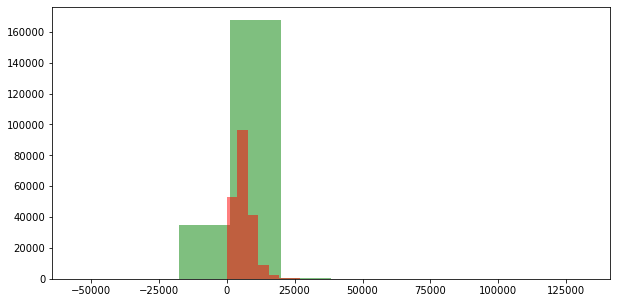

In [170]:
#실험 2
pred = model.predict(test_x)
pred = pred.reshape(pred.shape[0],1)
actual = test_y.values
feature = 'Min-Max'
target = 'None'
loss_function = 'mse'
filename = type_name(feature,target,loss_function)
make_resultfile(results,filename,pred,actual)
rmse = mean_squared_error(pred,test_y,squared=False)
print(rmse)

0.10006122741648164


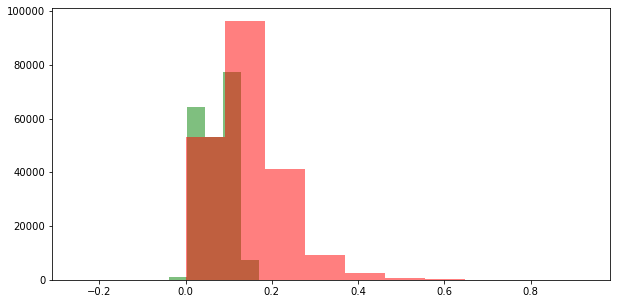

In [199]:
#실험 3
pred = model.predict(test_x)
pred = pred.reshape(pred.shape[0],1)
# pred = inverse_scaling(pred)
# actual = inverse_scaling(test_y)
actual = test_y.values
feature = 'Z-Score'
target = 'None'
loss_function = 'mse'
filename = type_name(feature,target,loss_function)
make_resultfile(results,filename,pred,actual)
rmse = mean_squared_error(pred,test_y,squared=False)
print(rmse)

3522.1425135632367


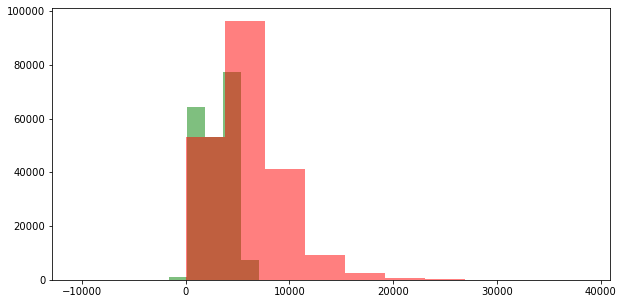

In [212]:
#실험 4
pred = model.predict(test_x)
pred = inverse_scaling(pred)
pred = pred.reshape(pred.shape[0],1)
actual = inverse_scaling(test_y)
# pred = inverse_scaling(pred)
# actual = inverse_scaling(test_y)
# actual = test_y.values
feature = 'None'
target = 'Min-Max'
loss_function = 'mse'
filename = type_name(feature,target,loss_function)
make_resultfile(results,filename,pred,actual)
rmse = mean_squared_error(pred,test_y,squared=False)
print(rmse)

1669.6692382303527


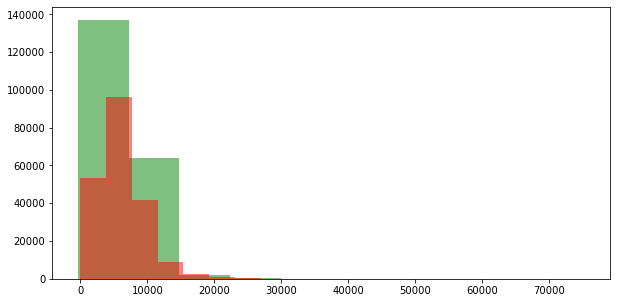

In [232]:
#실험 5
pred = model.predict(test_x)
pred = inverse_scaling(pred)
pred = pred.reshape(pred.shape[0],1)
actual = inverse_scaling(test_y)
# pred = inverse_scaling(pred)
# actual = inverse_scaling(test_y)
# actual = test_y.values
feature = 'Min-Max'
target = 'Min-Max'
loss_function = 'mse'
filename = type_name(feature,target,loss_function)
make_resultfile(results,filename,pred,actual)
rmse = mean_squared_error(pred,actual,squared=False)
print(rmse)

1537.6676819433708


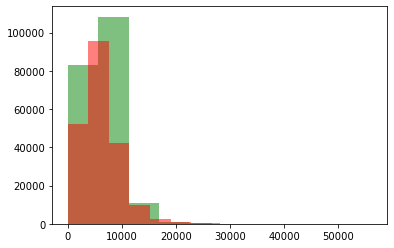

In [14]:
#실험 6
pred = model.predict(test_x)
pred = inverse_scaling(pred)
pred = pred.reshape(pred.shape[0],1)
actual = inverse_scaling(test_y)
# pred = inverse_scaling(pred)
# actual = inverse_scaling(test_y)
# actual = test_y.values
feature = 'Z-Score'
target = 'Min-Max'
loss_function = 'mse'
filename = type_name(feature,target,loss_function)
make_resultfile(results,filename,pred,actual)
rmse = mean_squared_error(pred,actual,squared=False)
print(rmse)

3309.3396462795477


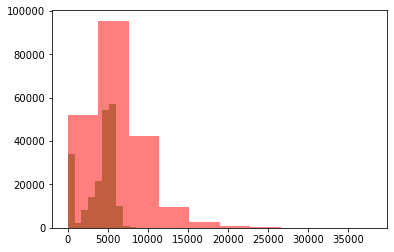

In [11]:
#실험 7
pred = model.predict(test_x)
pred = inverse_scaling(pred)
pred = pred.reshape(pred.shape[0],1)
actual = inverse_scaling(test_y)
# pred = inverse_scaling(pred)
# actual = inverse_scaling(test_y)
# actual = test_y.values
feature = 'None'
target = 'Z-Score'
loss_function = 'mse'
filename = type_name(feature,target,loss_function)
make_resultfile(results,filename,pred,actual)
rmse = mean_squared_error(pred,actual,squared=False)
print(rmse)

1798.5965263854555


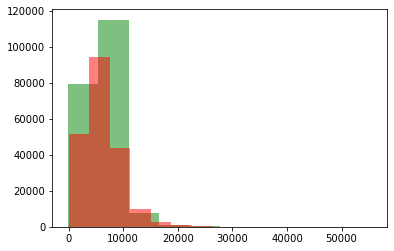

In [16]:
#실험 8
pred = model.predict(test_x)
pred = inverse_scaling(pred)
pred = pred.reshape(pred.shape[0],1)
actual = inverse_scaling(test_y)
# pred = inverse_scaling(pred)
# actual = inverse_scaling(test_y)
# actual = test_y.values
feature = 'Min-Max'
target = 'Z-Score'
loss_function = 'mse'
filename = type_name(feature,target,loss_function)
make_resultfile(results,filename,pred,actual)
rmse = mean_squared_error(pred,actual,squared=False)
print(rmse)

1475.4874663324265


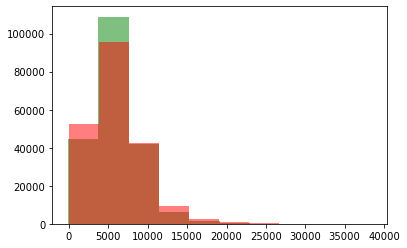

In [21]:
#실험 9
pred = model.predict(test_x)
pred = inverse_scaling(pred)
pred = pred.reshape(pred.shape[0],1)
actual = inverse_scaling(test_y)
# pred = inverse_scaling(pred)
# actual = inverse_scaling(test_y)
# actual = test_y.values
feature = 'Z-Score'
target = 'Z-Score'
loss_function = 'mse'
filename = type_name(feature,target,loss_function)
make_resultfile(results,filename,pred,actual)
rmse = mean_squared_error(pred,actual,squared=False)
print(rmse)

986622.9160711522


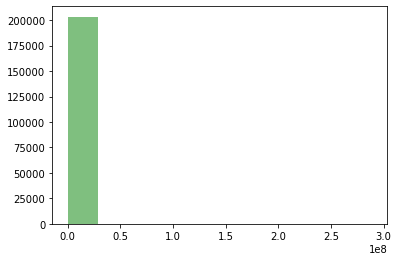

In [85]:
#실험 10
pred = model.predict(test_x)
pred = np.exp(pred)-1
pred = pred.reshape(pred.shape[0],1)
actual = inverse_scaling(test_y)
# pred = inverse_scaling(pred)
# actual = inverse_scaling(test_y)
# actual = test_y.values
feature = 'None'
target = 'Log'
loss_function = 'mse'
filename = type_name(feature,target,loss_function)
make_resultfile(results,filename,pred,actual)
rmse = mean_squared_error(pred,actual,squared=False)
print(rmse)

2150.6707356023744


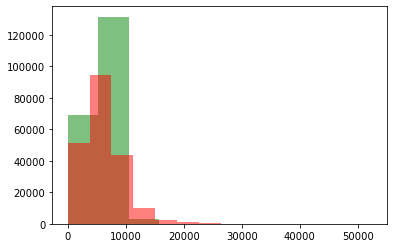

In [138]:
#실험 11
pred = model.predict(test_x)
pred = np.exp(pred)-1
pred = pred.reshape(pred.shape[0],1)
actual = np.exp(test_y)-1
actual = actual.values
# pred = inverse_scaling(pred)
# actual = inverse_scaling(test_y)
# actual = test_y.values
feature = 'Min-Max'
target = 'Log'
loss_function = 'mse'
filename = type_name(feature,target,loss_function)
make_resultfile(results,filename,pred,actual)
rmse = mean_squared_error(pred,actual,squared=False)
print(rmse)

1663.2892378768966


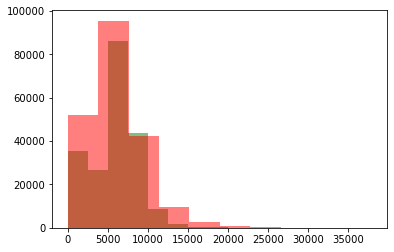

In [14]:
#실험 12
pred = model.predict(test_x)
pred = np.exp(pred)-1
pred = pred.reshape(pred.shape[0],1)
actual = np.exp(test_y)-1
actual = actual.values
# pred = inverse_scaling(pred)
# actual = inverse_scaling(test_y)
# actual = test_y.values
feature = 'Z-Score(test)'
target = 'Log'
loss_function = 'mse'
filename = type_name(feature,target,loss_function)
make_resultfile(results,filename,pred,actual)
rmse = mean_squared_error(pred,actual,squared=False)
print(rmse)

In [127]:
results

In [124]:
pred

array([[9.5155400e+03],
       [6.7733860e-01],
       [6.7508101e+03],
       ...,
       [4.5731924e+03],
       [5.1926699e+03],
       [5.9198110e+03]], dtype=float32)

In [125]:
actual

,0
262467,9904.0
490012,0.0
375278,4948.0
746640,2388.0
471359,7444.0
...,...
999710,7610.0
846341,0.0
698056,2992.0
1001087,5763.0


In [120]:
def make_resultfile(history,data,pred,actual) :
    filename = data
    
    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'])
    plt.legend(['mean_absolute_error','val_mean_absolute_error'])
    plt.xlabel('epochs')
    plt.ylabel('mean_absolute_error')
    plt.grid()
    plt.savefig(data[0])    
    plt.clf()
    
    aa=[x for x in range(1000)]
    plt.plot(aa, actual[:1000], marker='.', label="actual")
    plt.plot(aa, pred[:1000], 'r', label="prediction")
    plt.ylabel('Sales', size=15)
    plt.xlabel('Period', size=15)
    plt.legend(fontsize=15)
    plt.savefig(data[1])
    plt.clf()

    plt.hist(pred,alpha = 1.0,color='r')
    plt.hist(test_y,alpha = 0.5,color='r')
    plt.savefig(data[2])
    
    


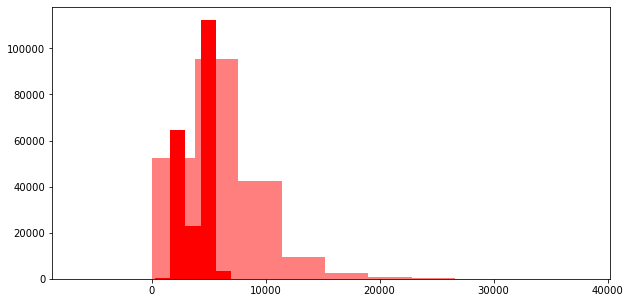

In [102]:
plt.hist(pred,alpha = 1.0,color='r')
plt.hist(test_y,alpha = 0.5,color='r')
plt.savefig('None_None_mse_hist')

In [ ]:
def make_resultfile(history,data,pred,actual) :
    filename = data
    
    plt.plot(history.history['mean_absolute_error'])
    plt.plot(history.history['val_mean_absolute_error'])
    plt.legend(['mean_absolute_error','val_mean_absolute_error'])
    plt.xlabel('epochs')
    plt.ylabel('mean_absolute_error')
    plt.grid()
    plt.savefig(data[0])    
    plt.clf()
    
#     aa=[x for x in range(1000)]
    plt.plot(actual[:1000], marker='.', label="actual")
    plt.plot(pred[:1000], 'r', label="prediction")
    plt.ylabel('Sales', size=15)
    plt.xlabel('Period', size=15)
    plt.legend(fontsize=15)
    plt.savefig(data[1],dpi=199)
    plt.clf()
    
    
    plt.plot(actual[:250], marker='.', label="actual")
    plt.plot(pred[:250], 'r', label="prediction")
    plt.ylabel('Sales', size=15)
    plt.xlabel('Period', size=15)
    plt.legend(fontsize=15)
    plt.savefig('pred_7')
    plt.clf()

    plt.hist(pred,alpha = 0.5,color='g')
    plt.hist(actual,alpha = 0.5,color='r')
    plt.savefig(data[2])

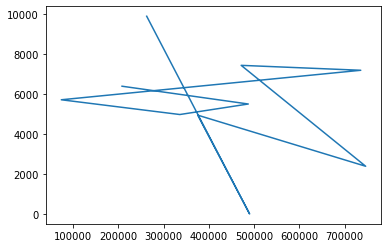

In [130]:
plt.plot(actual[:10])

In [135]:
actual.values

array([[9904.],
       [   0.],
       [4948.],
       ...,
       [2992.],
       [5763.],
       [4385.]])

In [134]:
pred

array([[9.5155400e+03],
       [6.7733860e-01],
       [6.7508101e+03],
       ...,
       [4.5731924e+03],
       [5.1926699e+03],
       [5.9198110e+03]], dtype=float32)

In [133]:
actual

,0
262467,9904.0
490012,0.0
375278,4948.0
746640,2388.0
471359,7444.0
...,...
999710,7610.0
846341,0.0
698056,2992.0
1001087,5763.0


In [ ]:
make_resultfile(results,filename,pred,actual)

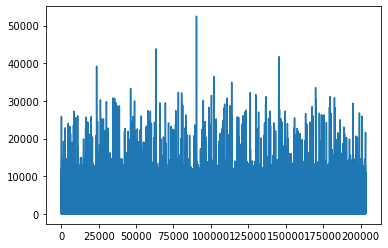

In [132]:
plt.plot(pred)

In [131]:
actual

,0
262467,9904.0
490012,0.0
375278,4948.0
746640,2388.0
471359,7444.0
...,...
999710,7610.0
846341,0.0
698056,2992.0
1001087,5763.0


In [12]:
pred = model.predict(test_x)
pred = pred.reshape(pred.shape[0],1)
mse = mean_squared_error(pred,test_y,squared=False)
print(mse)

6938.533184063133


# Standardization


In [4]:
train_x,test_x,val_x,train_y,test_y,val_y=processing_data(sales,store)

In [7]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(256,input_dim=train_x.shape[1],activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(256,activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(256,activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(128,activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam',
             loss='mse',
             metrics=[tf.keras.metrics.RootMeanSquaredError()])

model_path = 'D:/승찬/git/rossman'
checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=6)

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 256)               7424      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 256)               65792     
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 256)               6

In [9]:
results = model.fit(train_x, train_y,
                    validation_data=(val_x, val_y),
                    batch_size=64,
                    epochs=50,
                   callbacks=[checkpoint, early_stopping])

Epoch 1/50
9537/9537 [==============================] - ETA: 0s - loss: 19865554.0000 - root_mean_squared_error: 4457.0791
Epoch 00001: val_loss improved from inf to 7405108.50000, saving model to D:/승찬/git/rossman
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: D:/승찬/git/rossman\assets
9537/9537 [==============================] - 57s 6ms/step - loss: 19865554.0000 - root_mean_squared_error: 4457.0791 - val_loss: 7405108.5000 - val_root_mean_squared_error: 2721.2329
Epoch 2/50
9535/9537 [============================>.] - ETA: 0s - loss: 8524665.0000 - root_mean_squared_error: 2919.7029
Epoch 00002: val_loss did not improve from 7405108.50000
9537/9537 [==============================] - 52s 5ms/step - loss: 8524693.0000 - root_mean_squared_error: 2919.7078 - val_loss: 17421316.0000 - val_root_mean_squared_error: 4173.8848
Epoch 3/50
9530/9537 [============================>.] - ETA: 0s - loss: 8404309.0000 - root_mean_sq

In [7]:
test_y2 = inverse_scaling(test_y)

In [8]:
pred = model.predict(test_x)
pred = inverse_scaling(pred)
pred = pred.reshape(pred.shape[0],1)
mse = mean_squared_error(pred,test_y2,squared=False)
print(mse)

1513.7057285598057


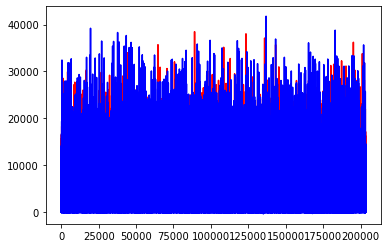

In [11]:
plt.plot(np.arange(1,len(test_y2)+1),test_y2,'r')
plt.plot(np.arange(1,len(test_y2)+1),pred,'b')

(array([5.3170e+04, 9.6432e+04, 4.1331e+04, 9.0650e+03, 2.4290e+03,
        7.4300e+02, 1.9300e+02, 6.2000e+01, 1.0000e+01, 7.0000e+00]),
 array([-1.49972273, -0.50011866,  0.49948541,  1.49908949,  2.49869356,
         3.49829764,  4.49790171,  5.49750579,  6.49710986,  7.49671394,
         8.49631801]),
 <BarContainer object of 10 artists>)

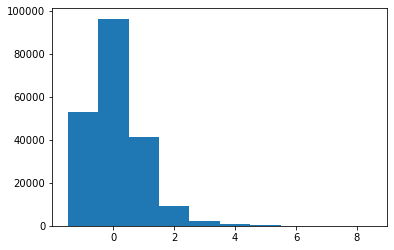

In [9]:
plt.hist(test_y)

(array([4.69110e+04, 1.11325e+05, 3.82190e+04, 5.27700e+03, 1.03300e+03,
        3.54000e+02, 1.98000e+02, 9.00000e+01, 3.00000e+01, 5.00000e+00]),
 array([ -364.2494,  3849.4302,  8063.11  , 12276.789 , 16490.469 ,
        20704.148 , 24917.828 , 29131.508 , 33345.188 , 37558.867 ,
        41772.547 ], dtype=float32),
 <BarContainer object of 10 artists>)

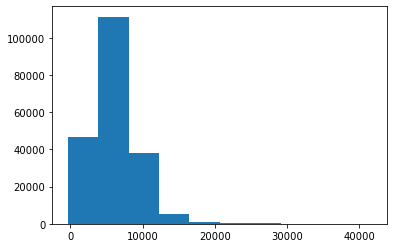

In [10]:
plt.hist(pred)

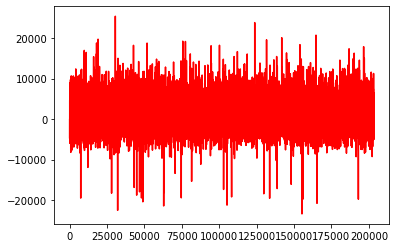

In [28]:
error_dnn2 = test_y2-pred
plt.plot(np.arange(1,len(test_y)+1),error_dnn2,'r')

# Min-Max


In [4]:
train_x,test_x,val_x,train_y,test_y,val_y=processing_data(sales,store)

In [40]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(256,input_dim=train_x.shape[1],activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(256,activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(256,activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(128,activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.BatchNormalization())

model.add(tf.keras.layers.Dense(1))

model.compile(optimizer='adam',
             loss='mse',
             metrics=['mean_absolute_error'])

model_path = 'D:/승찬/git/rossman'
checkpoint = ModelCheckpoint(filepath=model_path , monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=6)

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 256)               7424      
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
batch_normalization_16 (Batc (None, 256)               1024      
_________________________________________________________________
dense_21 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_17 (Dropout)         (None, 256)               0         
_________________________________________________________________
batch_normalization_17 (Batc (None, 256)               1024      
_________________________________________________________________
dense_22 (Dense)             (None, 256)              

In [ ]:
results_min_max = model.fit(train_x, train_y,
                    validation_data=(val_x, val_y),
                    batch_size=64,
                    epochs=50,
                   callbacks=[checkpoint, early_stopping])

Epoch 1/50
  63/9537 [..............................] - ETA: 30:13 - loss: 0.8819 - mean_absolute_error: 0.7377

In [30]:
pred = model.predict(test_x)
pred

array([[0.10762869],
       [0.4099143 ],
       [0.1793447 ],
       ...,
       [0.15745543],
       [0.00938755],
       [0.17041114]], dtype=float32)

(array([5.2151e+04, 9.5476e+04, 4.2529e+04, 9.5620e+03, 2.5540e+03,
        8.5000e+02, 2.0900e+02, 8.7000e+01, 1.7000e+01, 7.0000e+00]),
 array([    0. ,  3803.7,  7607.4, 11411.1, 15214.8, 19018.5, 22822.2,
        26625.9, 30429.6, 34233.3, 38037. ]),
 <BarContainer object of 10 artists>)

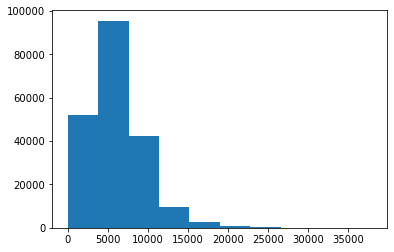

In [25]:
plt.hist(test_y2)

(array([1.98923e+05, 4.23600e+03, 6.10000e+01, 5.10000e+01, 3.90000e+01,
        5.20000e+01, 4.40000e+01, 1.60000e+01, 1.50000e+01, 5.00000e+00]),
 array([-0.08301012,  0.30130953,  0.6856292 ,  1.0699488 ,  1.4542685 ,
         1.8385881 ,  2.2229078 ,  2.6072276 ,  2.991547  ,  3.375867  ,
         3.7601864 ], dtype=float32),
 <BarContainer object of 10 artists>)

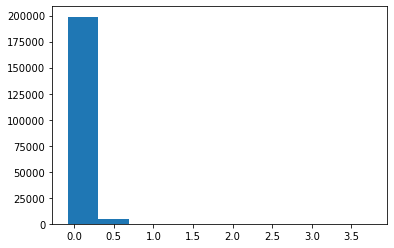

In [31]:
plt.hist(pred)

In [32]:
pred

array([[0.10762869],
       [0.4099143 ],
       [0.1793447 ],
       ...,
       [0.15745543],
       [0.00938755],
       [0.17041114]], dtype=float32)

In [37]:
test_y

,0
348271,0.084113
211646,0.231956
917385,0.148925
327969,0.160550
210099,0.282905
...,...
15193,0.142548
136055,0.135424
928577,0.261005
57070,0.000000


In [19]:
pred = inverse_scaling(pred)

In [26]:
pred

array([[ 4472.0796],
       [17032.35  ],
       [ 7451.9517],
       ...,
       [ 6542.4307],
       [  390.0622],
       [ 7080.7534]], dtype=float32)

In [ ]:
pred = model.predict(test_x)
pred = inverse_scaling(pred)
pred = pred.reshape(pred.shape[0],1)
mse = mean_squared_error(pred,test_y2,squared=False)
print(mse)

In [27]:
mse = mean_squared_error(pred,test_y2,squared=False)
print(mse)

2910.753111188598


In [28]:
mse = mean_squared_error(pred,test_y2,squared=True)
print(mse)

8472483.674294103


In [34]:
test_y2 = inverse_scaling(test_y)

In [35]:
test_y2

array([[ 3495.],
       [ 9638.],
       [ 6188.],
       ...,
       [10845.],
       [    0.],
       [ 6598.]])

In [28]:
len(pred)

203442

In [27]:
pred-test_y2 / 203442

array([[-1407.01123047],
       [    7.76660156],
       [-1061.30371094],
       ...,
       [ 1763.9140625 ],
       [  236.24365234],
       [ 1127.96386719]])

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [53]:
df = pd.DataFrame(np.array([0,2,3,4,7,11,12,103,104,1005,1006,1007]),columns=['col'])

In [90]:
df

,col
0,0
1,2
2,3
3,4
4,7
5,11
6,12
7,103
8,104
9,1005


In [91]:
np.log1p(df)

,col
0,0.000000
1,1.098612
2,1.386294
3,1.609438
4,2.079442
5,2.484907
6,2.564949
7,4.644391
8,4.653960
9,6.913737


In [94]:
np.exp(2)

7.38905609893065

In [55]:
np.log1p(df)

,col
0,0.000000
1,1.098612
2,1.386294
3,1.609438
4,2.079442
5,2.484907
6,2.564949
7,4.644391
8,4.653960
9,6.913737


In [56]:
df

,col
0,0
1,2
2,3
3,4
4,7
5,11
6,12
7,103
8,104
9,1005


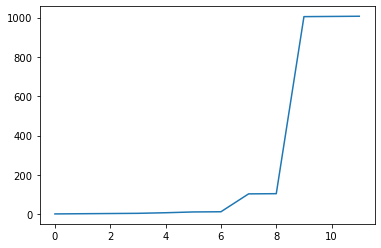

In [28]:
plt.plot(df)

In [43]:
df['log_col'] = np.log1p(df['col'])

In [40]:
df['log_col'] = np.log10(df['col'])